# ARIMA Model Selection

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
import warnings

from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
data.head()


,SpotPriceDKK,from,to,mean_temp_Aabenraa,mean_temp_Aalborg,mean_temp_Aarhus,mean_temp_Assens,mean_temp_Billund,mean_temp_Brønderslev,mean_temp_Esbjerg,...,wind_dir_W_Syddjurs,wind_dir_W_Sønderborg,wind_dir_W_Thisted,wind_dir_W_Tønder,wind_dir_W_Varde,wind_dir_W_Vejen,wind_dir_W_Vejle,wind_dir_W_Vesthimmerlands,wind_dir_W_Viborg,wind_dir_W_Ærø
0,291.329987,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,...,False,False,False,False,False,False,False,False,False,False
1,240.389999,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,...,False,False,False,False,False,False,False,False,False,False
2,241.880005,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,...,False,False,False,False,False,False,False,False,False,False
3,444.450012,2024-10-20 02:00:00+00:00,2024-10-20 03:00:00+00:00,12.4,11.4,11.6,12.5,12.0,11.5,12.4,...,False,False,False,False,False,False,False,False,False,False
4,417.000000,2024-10-20 01:00:00+00:00,2024-10-20 02:00:00+00:00,12.4,11.8,11.2,12.4,11.7,12.1,12.3,...,False,False,False,False,False,False,False,False,False,False


## ARIMA Model Parameter Selection

To determine the best parameters for an ARIMA model using only the `SpotPriceDKK` column, we will follow these steps:

1. **Data Preparation**: Extract the `SpotPriceDKK` column and ensure it is in the correct format for time series analysis.
2. **Stationarity Check**: Perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
3. **ACF and PACF Plots**: Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify potential values for the ARIMA parameters (p, d, q).
4. **Model Selection**: Fit ARIMA models with different combinations of parameters and select the best model based on criteria such as AIC (Akaike Information Criterion).

Let's start with the data preparation and stationarity check.
```

In [3]:
# Extract the 'SpotPriceDKK' column
spot_price = data['SpotPriceDKK']

# Convert the index to datetime if it's not already
data['from'] = pd.to_datetime(data['from'])
data.set_index('from', inplace=True)

# Display the first few rows of the prepared data
spot_price.head()

0    291.329987
1    240.389999
2    241.880005
3    444.450012
4    417.000000
Name: SpotPriceDKK, dtype: float64

In [4]:
# Differentiate the spot_price series once
spot_price_diff = spot_price.diff().dropna()

# Display the first few rows of the differentiated series
spot_price_diff.head()

# Perform the Augmented Dickey-Fuller test on the differentiated series
adf_test_diff = adfuller(spot_price_diff)

# Extract and display the test results
adf_result_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_result_diff[f'Critical Value ({key})'] = value

print(adf_result_diff)


Test Statistic                    -57.209559
p-value                             0.000000
#Lags Used                         71.000000
Number of Observations Used    120918.000000
Critical Value (1%)                -3.430404
Critical Value (5%)                -2.861564
Critical Value (10%)               -2.566783
dtype: float64


#### We can see that our data is already stationary and there is no reason to differentiate further

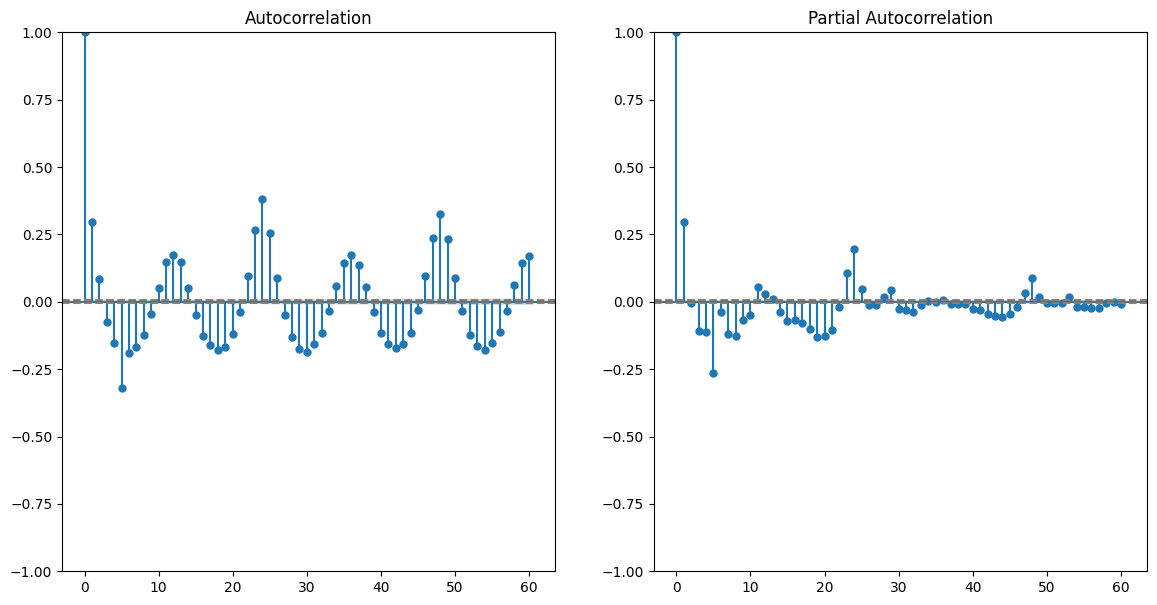

In [8]:
# Calculate the confidence intervals for ACF and PACF
conf_acf = 1.96 / (len(spot_price_diff) ** 0.5)
conf_pacf = 1.96 / (len(spot_price_diff) ** 0.5)

# Plot ACF with confidence intervals
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_acf, linestyle='--', color='gray')
plt.axhline(y=-conf_acf, linestyle='--', color='gray')

# Plot PACF with confidence intervals
plt.subplot(122)
plot_pacf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_pacf, linestyle='--', color='gray')
plt.axhline(y=-conf_pacf, linestyle='--', color='gray')

plt.show()

In [6]:
auto_arima_model = pm.auto_arima(
    spot_price_diff[:1000],  # Use the first 1000 rows
    seasonal=True,
    m=24,
    trace=True,
    suppress_warnings=True
)

# Display the summary of the model
print(auto_arima_model.summary())




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=12885.218, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=12503.190, Time=0.68 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=12516.734, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=12883.221, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=12701.623, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=12432.378, Time=3.61 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=14.89 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=12484.419, Time=1.09 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=12361.091, Time=4.18 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=12437.506, Time=0.88 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=10.25 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(3,0,0)(2,0,0)[24] intercep

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(1,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
    ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ~~~~~~~~~~~~^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/l

 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=12365.653, Time=4.52 sec
 ARIMA(3,0,1)(2,0,0)[24] intercept   : AIC=inf, Time=11.81 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=inf, Time=13.36 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=inf, Time=11.94 sec
 ARIMA(3,0,2)(2,0,0)[24] intercept   : AIC=inf, Time=13.84 sec
 ARIMA(2,0,1)(2,0,0)[24]             : AIC=12354.025, Time=3.99 sec
 ARIMA(2,0,1)(1,0,0)[24]             : AIC=12411.008, Time=0.90 sec
 ARIMA(2,0,1)(2,0,1)[24]             : AIC=inf, Time=16.67 sec
 ARIMA(2,0,1)(1,0,1)[24]             : AIC=inf, Time=1.79 sec
 ARIMA(1,0,1)(2,0,0)[24]             : AIC=12363.649, Time=2.27 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=12359.090, Time=2.10 sec
 ARIMA(3,0,1)(2,0,0)[24]             : AIC=inf, Time=9.31 sec
 ARIMA(2,0,2)(2,0,0)[24]             : AIC=inf, Time=10.75 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=12430.377, Time=1.77 sec
 ARIMA(1,0,2)(2,0,0)[24]     

In [9]:
auto_arima_model = pm.auto_arima(
    spot_price_diff[:5000],  # Use the first 5000 rows
    seasonal=True,
    m=24,
    trace=True,
    suppress_warnings=True
)

# Display the summary of the model
print(auto_arima_model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=29.44 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=63770.818, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=61758.951, Time=3.38 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=62092.467, Time=2.60 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=63768.819, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=62885.974, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=61425.120, Time=17.21 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=58.91 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=10.40 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=61574.210, Time=4.34 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=61282.679, Time=23.11 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=61645.081, Time=4.31 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=45.17 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=11.61 sec
 ARIMA(3,0,0)(2,0,0)[24] int

In [11]:
# Fit the ARIMA model
arima_model = SARIMAX(spot_price_diff, order=(5, 0, 0), seasonal_order=(2, 0, 0, 24))
arima_result = arima_model.fit(disp=False)

# Display the summary of the model
print(arima_result.summary())


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


: 